In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ['TORCH_USE_CUDA_DSA'] = "TRUE"
os.environ['CUDA_LAUNCH_BLOCKING']="TRUE"

In [3]:
from use_case.baseline import * 
from models.eval import *

np.random.seed(1337)
torch.manual_seed(1337)

N = 10
payoff_i = np.random.randint(-10, 10, (N, N))
payoff_j = np.random.randint(-10, 10, (N, N))

# Initialize environment
N_ACTIONS = payoff_i.shape[0]
N_AGENTS = 500
env = BaselineEnvironment(N_AGENTS, payoff_i, payoff_j, total_games = 5)

In [4]:
for i in range(N):
    for j in range(N):
        print(f"({payoff_i[i, j]:.2f}, {payoff_j[i, j]:.2f})", end = "\t")
    print("\n")

(-2.00, -2.00)	(-3.00, 9.00)	(-3.00, -1.00)	(8.00, -6.00)	(8.00, -3.00)	(-2.00, -9.00)	(-1.00, -3.00)	(-4.00, 0.00)	(-9.00, -3.00)	(-4.00, -7.00)	

(8.00, 1.00)	(-8.00, -5.00)	(-1.00, 0.00)	(-2.00, 5.00)	(1.00, -1.00)	(-9.00, 7.00)	(9.00, -10.00)	(4.00, -8.00)	(7.00, -6.00)	(5.00, -6.00)	

(9.00, -1.00)	(-7.00, -4.00)	(-2.00, 7.00)	(-2.00, -4.00)	(-3.00, 8.00)	(-1.00, 2.00)	(-6.00, 4.00)	(-9.00, -1.00)	(2.00, -10.00)	(-4.00, -5.00)	

(-6.00, 7.00)	(8.00, 8.00)	(4.00, -5.00)	(8.00, -8.00)	(-7.00, 7.00)	(-1.00, 4.00)	(-8.00, 9.00)	(0.00, 1.00)	(-6.00, 7.00)	(-2.00, -9.00)	

(4.00, 9.00)	(-4.00, -3.00)	(-7.00, -6.00)	(-2.00, -3.00)	(5.00, 2.00)	(-3.00, 2.00)	(-6.00, -4.00)	(-7.00, -1.00)	(8.00, 2.00)	(-1.00, -6.00)	

(7.00, -6.00)	(3.00, -8.00)	(8.00, 5.00)	(2.00, 8.00)	(6.00, -4.00)	(3.00, -9.00)	(9.00, 3.00)	(8.00, 6.00)	(-9.00, 6.00)	(3.00, -2.00)	

(-10.00, 9.00)	(7.00, 3.00)	(-1.00, -4.00)	(3.00, 8.00)	(-8.00, -9.00)	(6.00, 9.00)	(6.00, -7.00)	(-3.00, -5.00)	(-4.00, -1.00)	(2.00, -8.

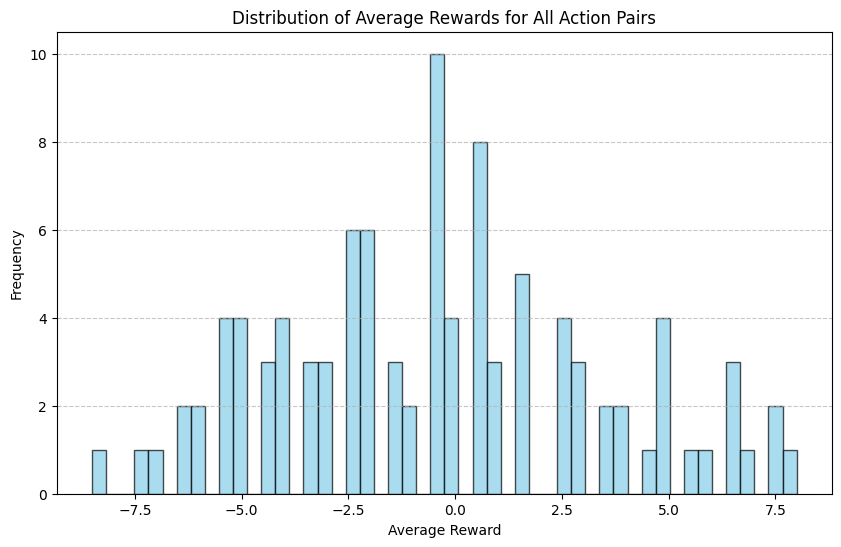

In [5]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import matplotlib.pyplot as plt

# Calculate average rewards for all action pairs
average_rewards = (payoff_i + payoff_j) / 2

# Flatten the matrix into a list of all possible rewards
all_rewards = average_rewards.ravel()

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(all_rewards, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Average Rewards for All Action Pairs')
plt.xlabel('Average Reward')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

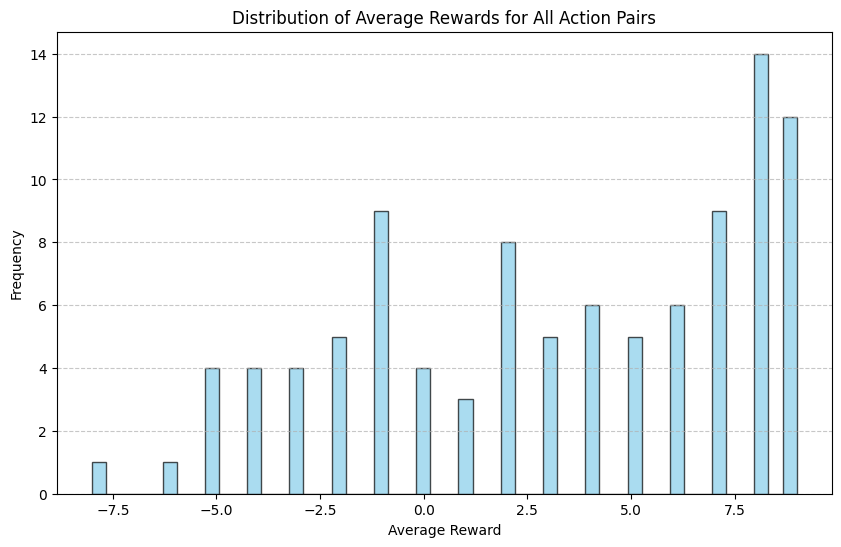

In [6]:

# Calculate average rewards for all action pairs
max_rewards = np.max([payoff_i, payoff_j], axis = 0)

# Flatten the matrix into a list of all possible rewards
all_rewards = max_rewards.ravel()

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(all_rewards, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Average Rewards for All Action Pairs')
plt.xlabel('Average Reward')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Actual Run

In [7]:
from models.model import *
from models.trainer import *

In [8]:
# Configure the network here
parameters = ParameterSettings(
    n_agents = N_AGENTS,
    d_action = N_ACTIONS, 
    d_obs = env.obs_size, 
    d_traits = env.d_traits,
    d_het_latent = 4, 
    d_beliefs = env.d_beliefs,
    d_relation = env.d_relation
)
parameters.device = "cuda" if torch.cuda.is_available() else "cpu"
model = PPOModel(parameters)

In [9]:
equilibriua = find_pure_equilibria(payoff_i, payoff_j)

for eq in equilibriua:
    x, y = eq 
    a = (y[0] + y[1]) / 2

    print(x, a)

(7, 8) 6.5
(9, 5) 7.5


In [10]:
evaluate_policy(model, env, 10, temperature=2.0)

np.float64(-12.831000000000001)

In [11]:
# Setup the training loop
training_parameters = TrainingParameters(
    outer_loops = 2_000,
    
    actor_learning_rate= 1e-4,
    critic_learning_rate = 1e-3,
    hypernet_learning_rate = 5e-4,

    hypernet_jsd_threshold = 0.5,
    hypernet_samples = 3000,
    hypernet_jsd_weight = 1.0,
    hypernet_entropy_weight = 0.01, 
    hypernet_diversity_weight= 1.0,

    sampled_agents_proportion = 0.5,
    experience_sampling_steps = 10,
    experience_buffer_size = 10,

    entropy_coeff = 0.2,

    epsilon_period = 200,
    epsilon_end = 0.05,

    entropy_target = 0.5,

    eval_temp = -1.0,
    
    # verbose = False,
    device = parameters.device,
    steps_per_epoch = 4
)
train_model(model, env, training_parameters)
        

100%|██████████| 2000/2000 [2:26:14<00:00,  4.39s/it]  


# Heterogeneous Baseline

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from use_case.baseline import * 
from models.eval import *
from models.model import *
from models.trainer import *


In [ ]:
np.random.seed(1337)
torch.manual_seed(1337)

N_AGENTS = 1000
N_TYPES = 5
N_ACTIONS = 10
type_payoffs = np.random.uniform(-10, 10, (N_TYPES, N_TYPES, 2, N_ACTIONS, N_ACTIONS))
env = BaselineHeterogeneous(N_AGENTS, N_TYPES, type_payoffs, total_games = 4)

In [ ]:
# Configure the network here
parameters = ParameterSettings(
    n_agents = N_AGENTS,
    d_action = N_ACTIONS, 
    d_obs = env.obs_size, 
    d_traits = env.d_traits,
    d_het_latent = 4, 
    d_beliefs = env.d_beliefs,
    d_relation = env.d_relation,
    d_comm_state= env.d_comm_state,
    device = "cuda"
)

model = PPOModel(parameters)

In [ ]:
# Setup the training loop
training_parameters = TrainingParameters(
    outer_loops = 10_000,
    
    actor_learning_rate= 1e-4,
    critic_learning_rate = 1e-3,
    hypernet_learning_rate = 5e-4,

    hypernet_jsd_threshold = 0.5,
    hypernet_samples = 10000,
    hypernet_jsd_weight = 1.0,
    hypernet_entropy_weight = 1.0, 
    hypernet_diversity_weight= 1.0,

    sampled_agents_proportion = 0.5,
    experience_sampling_steps = 10,
    experience_buffer_size = 100,

    entropy_coeff = 0.2,

    epsilon_period = 1000,
    epsilon_end = 0.2,

    entropy_target = 0.5,

    eval_temp = -1.0,
    
    verbose = False,
    device = parameters.device,
    eval_k= N_TYPES,
    checkpoint_interval = 100
)
train_model(model, env, training_parameters)
